In [1]:
# -*- coding: utf-8 -*-
"""
Created on Tue June 26 14:43:38 2016

@author: Chris
"""
import pandas
import numpy
import matplotlib.pyplot as plt
import seaborn
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats

#from IPython.display import display
%matplotlib inline

#bug fix for display formats to avoid run time errors
pandas.set_option('display.float_format', lambda x:'%f'%x)

#Set Pandas to show all columns in DataFrame
pandas.set_option('display.max_columns', None)
#Set Pandas to show all rows in DataFrame
pandas.set_option('display.max_rows', None)

#data here will act as the data frame containing the Mars crater data
data = pandas.read_csv('D:\\Coursera\\marscrater_pds.csv', low_memory=False)

#convert the latitude and diameter columns to numeric and ejecta morphology is categorical
data['LATITUDE_CIRCLE_IMAGE'] = pandas.to_numeric(data['LATITUDE_CIRCLE_IMAGE'])
data['DIAM_CIRCLE_IMAGE'] = pandas.to_numeric(data['DIAM_CIRCLE_IMAGE'])
data['MORPHOLOGY_EJECTA_1'] = data['MORPHOLOGY_EJECTA_1'].astype('category')

#Any crater with no designated morphology will be replaced with NaN
data['MORPHOLOGY_EJECTA_1'] = data['MORPHOLOGY_EJECTA_1'].replace(' ',numpy.NaN)

In [2]:
#Here we will subset out craters with the three ejecta morphologies we are interested in
morphofinterest = ['Rd','SLEPS','SLERS']
data = data.loc[data['MORPHOLOGY_EJECTA_1'].isin(morphofinterest)]
data.head(5)

,CRATER_ID,CRATER_NAME,LATITUDE_CIRCLE_IMAGE,LONGITUDE_CIRCLE_IMAGE,DIAM_CIRCLE_IMAGE,DEPTH_RIMFLOOR_TOPOG,MORPHOLOGY_EJECTA_1,MORPHOLOGY_EJECTA_2,MORPHOLOGY_EJECTA_3,NUMBER_LAYERS
8,01-000008,,75.539000,13.829000,58.400000,0.110000,Rd,,,0
12,01-000012,Dokka,77.170000,-145.681000,51.080000,1.740000,Rd,,,0
25,01-000025,,70.051000,-7.939000,39.510000,2.080000,SLERS,HuSL,,1
28,01-000028,Louth,70.173000,103.226000,36.280000,1.410000,SLERS,HuBL,,1
37,01-000037,,77.116000,89.130000,30.880000,0.710000,SLERS,HuSL,,1


In [3]:
#We now center the data
data['CENTERED_LATITUDE'] = (data['LATITUDE_CIRCLE_IMAGE'] - data['LATITUDE_CIRCLE_IMAGE'].mean())
data['CENTERED_LONGITUDE'] = (data['LONGITUDE_CIRCLE_IMAGE'] - data['LONGITUDE_CIRCLE_IMAGE'].mean())

In [4]:
#We now look at our data now that we've extracted the data we wish to use
data[['LATITUDE_CIRCLE_IMAGE','LONGITUDE_CIRCLE_IMAGE','CENTERED_LATITUDE','CENTERED_LONGITUDE']].describe()

,LATITUDE_CIRCLE_IMAGE,LONGITUDE_CIRCLE_IMAGE,CENTERED_LATITUDE,CENTERED_LONGITUDE
count,34669.000000,34669.000000,34669.000000,34669.000000
mean,-8.197657,9.975703,0.000000,0.000000
std,34.678085,97.580907,34.678085,97.580907
min,-86.560000,-179.986000,-78.362343,-189.961703
25%,-33.068000,-60.434000,-24.870343,-70.409703
50%,-10.561000,14.921000,-2.363343,4.945297
75%,15.531000,87.690000,23.728657,77.714297
max,82.218000,179.991000,90.415657,170.015297


In [5]:
#Because of the bug in seaborn plotting, we now extract the data from the original data frame as arrays and make a new data frame
latitude = numpy.array(data['LATITUDE_CIRCLE_IMAGE'])
diameter = numpy.array(data['DIAM_CIRCLE_IMAGE'])
morphology = numpy.array(data['MORPHOLOGY_EJECTA_1'])
latitudecenter = numpy.array(data['CENTERED_LATITUDE'])
longitude = numpy.array(data['LONGITUDE_CIRCLE_IMAGE'])
depth = numpy.array(data['DEPTH_RIMFLOOR_TOPOG'])
layers = numpy.array(data['NUMBER_LAYERS'])
longitudecenter = numpy.array(data['CENTERED_LONGITUDE'])
data2 = pandas.DataFrame({'LATITUDE':latitude,
                          'DIAMETER':diameter,
                          'MORPHOLOGY_EJECTA_1':morphology,
                          'CENTERED_LATITUDE':latitudecenter,
                          'LONGITUDE':longitude,
                          'CENTERED_LONGITUDE':longitudecenter,
                          'DEPTH':depth,
                          'NUMBER_LAYERS':layers})

We now do linear regression for diameter onto latitude for the different ejecta morphologyies.


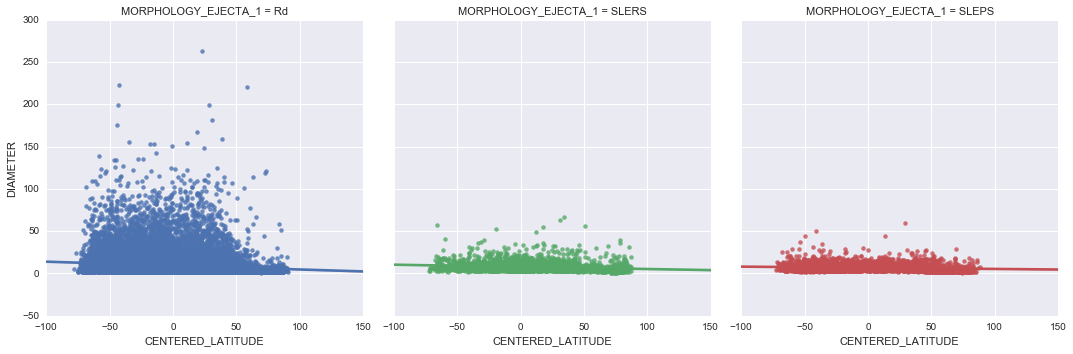

In [6]:
print('We now do linear regression for diameter onto latitude for the different ejecta morphologyies.')
seaborn.lmplot(x='CENTERED_LATITUDE',y='DIAMETER',col='MORPHOLOGY_EJECTA_1',hue='MORPHOLOGY_EJECTA_1',data=data2)

In [7]:
#First, let's add in the morphology, longitude, rim depth, and number of layers in our model and see whether
#there are any potential confounding variables
model1 = smf.ols(formula = 'DIAMETER ~ CENTERED_LATITUDE + CENTERED_LONGITUDE + DEPTH \
                 + NUMBER_LAYERS + C(MORPHOLOGY_EJECTA_1)',data=data2).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:               DIAMETER   R-squared:                       0.458
Model:                            OLS   Adj. R-squared:                  0.458
Method:                 Least Squares   F-statistic:                     4887.
Date:                Sun, 26 Jun 2016   Prob (F-statistic):               0.00
Time:                        16:53:47   Log-Likelihood:            -1.2512e+05
No. Observations:               34669   AIC:                         2.503e+05
Df Residuals:                   34662   BIC:                         2.503e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------------
Intercept 

In [8]:
#We notice in this model, that from the p values (<0.05) of the coefficients, that longitude, morphology, and crater 
#depth all show an effect on the final diameter of our crater. Only the number of layers within the crater shows little
#association, so we can safely remove that from our model.

#The surprising association of crater diameter with morphology ejecta type warrants me to separate out craters based on
#their ejecta morphology. Perhaps not too surprising, but the depth of the crater shows the strongest correlation between
#the craters diameter (large coefficient compared to latitude and longitude). We now look at the data one at a time.

In [9]:
model2 = smf.ols(formula = 'DIAMETER ~ CENTERED_LATITUDE + CENTERED_LONGITUDE',data=data2).fit()
print(model2.summary())
#Here we still that longitude as a potential confounder

                            OLS Regression Results                            
Dep. Variable:               DIAMETER   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     250.3
Date:                Sun, 26 Jun 2016   Prob (F-statistic):          1.16e-108
Time:                        16:53:47   Log-Likelihood:            -1.3550e+05
No. Observations:               34669   AIC:                         2.710e+05
Df Residuals:                   34666   BIC:                         2.710e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept              8.7936      0

In [10]:
model3 = smf.ols(formula = 'DIAMETER ~ CENTERED_LATITUDE + DEPTH',data=data2).fit()
print(model3.summary())
#Crater is also another potential confounder as th ep value si quite small and we have a large coefficient for depth

                            OLS Regression Results                            
Dep. Variable:               DIAMETER   R-squared:                       0.435
Model:                            OLS   Adj. R-squared:                  0.435
Method:                 Least Squares   F-statistic:                 1.337e+04
Date:                Sun, 26 Jun 2016   Prob (F-statistic):               0.00
Time:                        16:53:47   Log-Likelihood:            -1.2583e+05
No. Observations:               34669   AIC:                         2.517e+05
Df Residuals:                   34666   BIC:                         2.517e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept             0.4150      0.07

In [11]:
model4 = smf.ols(formula = 'DIAMETER ~ CENTERED_LATITUDE + NUMBER_LAYERS',data=data2).fit()
print(model4.summary())
#Oddly enough, when we only account for the latitude and number of layers within the craters, the number of layers shows a
#negative correlation and is significant. It is only when we add other variables does this disappear.

                            OLS Regression Results                            
Dep. Variable:               DIAMETER   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     325.9
Date:                Sun, 26 Jun 2016   Prob (F-statistic):          5.82e-141
Time:                        16:53:47   Log-Likelihood:            -1.3542e+05
No. Observations:               34669   AIC:                         2.708e+05
Df Residuals:                   34666   BIC:                         2.709e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept             9.3555      0.07

In [12]:
model5 = smf.ols(formula = 'DIAMETER ~ CENTERED_LATITUDE + CENTERED_LONGITUDE + DEPTH + NUMBER_LAYERS',data=data2).fit()
print(model5.summary())
#One last check is to remove any categorical variables. When we do this, the number of layers becomes significant again 

                            OLS Regression Results                            
Dep. Variable:               DIAMETER   R-squared:                       0.457
Model:                            OLS   Adj. R-squared:                  0.457
Method:                 Least Squares   F-statistic:                     7282.
Date:                Sun, 26 Jun 2016   Prob (F-statistic):               0.00
Time:                        16:53:47   Log-Likelihood:            -1.2517e+05
No. Observations:               34669   AIC:                         2.504e+05
Df Residuals:                   34664   BIC:                         2.504e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept              1.3141      0

In [13]:
#For this analysis, because morphology ejecta may be a potential confounder, we will limit our data to only those craters
#with a morphology of Rd (radial pancake), and look at the latitude and longitude of a given crater, because the original study
#was mostly concerned with relating the diameter of a given crater with its location of impact (of which crater ejecta morphology)
#provided a hint about the underlying terrain which also from the literature has implicit correlation with the crater diameter
#after impact.

data3 = data2.loc[data2['MORPHOLOGY_EJECTA_1'].isin(['Rd'])]

#Because of the bug in seaborn plotting, we now extract the data from the original data frame as arrays and make a new data frame
latitude = numpy.array(data2['LATITUDE'])
diameter = numpy.array(data2['DIAMETER'])
morphology = numpy.array(data2['MORPHOLOGY_EJECTA_1'])
latitudecenter = numpy.array(data2['CENTERED_LATITUDE'])
longitude = numpy.array(data2['LONGITUDE'])
depth = numpy.array(data2['DEPTH'])
layers = numpy.array(data2['NUMBER_LAYERS'])
longitudecenter = numpy.array(data2['CENTERED_LONGITUDE'])
data3 = pandas.DataFrame({'LATITUDE':latitude,
                          'DIAMETER':diameter,
                          'MORPHOLOGY_EJECTA_1':morphology,
                          'CENTERED_LATITUDE':latitudecenter,
                          'LONGITUDE':longitude,
                          'CENTERED_LONGITUDE':longitudecenter,
                          'DEPTH':depth,
                          'NUMBER_LAYERS':layers})

In [14]:
model6 = smf.ols(formula = 'DIAMETER ~ CENTERED_LATITUDE + CENTERED_LONGITUDE ',data=data3).fit()
print(model6.summary())
model7 = smf.ols(formula = 'DIAMETER ~ CENTERED_LATITUDE + I(CENTERED_LATITUDE**2) + CENTERED_LONGITUDE',data=data3).fit()
print(model7.summary())
#We notice that a warning from Python telling us that we have a large condition number when we try to include a polynomial
#term to our model and also that introducing this term results in no better R-squared value. Therefore we will stick to model6
#for our analysis

                            OLS Regression Results                            
Dep. Variable:               DIAMETER   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     250.3
Date:                Sun, 26 Jun 2016   Prob (F-statistic):          1.16e-108
Time:                        16:53:47   Log-Likelihood:            -1.3550e+05
No. Observations:               34669   AIC:                         2.710e+05
Df Residuals:                   34666   BIC:                         2.710e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept              8.7936      0

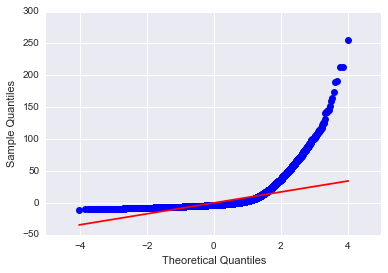

In [15]:
#QQ plot for normality
fig1 = sm.qqplot(model6.resid,line='r')

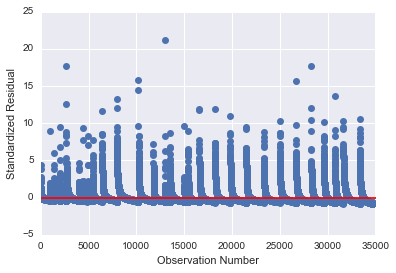

In [16]:
#Plot of the residuals
stdres = pandas.DataFrame(model6.resid_pearson)
plt.plot(stdres, 'o',ls='None')
l = plt.axhline(y=0, color='r')
plt.xlabel('Observation Number')
plt.ylabel('Standardized Residual')

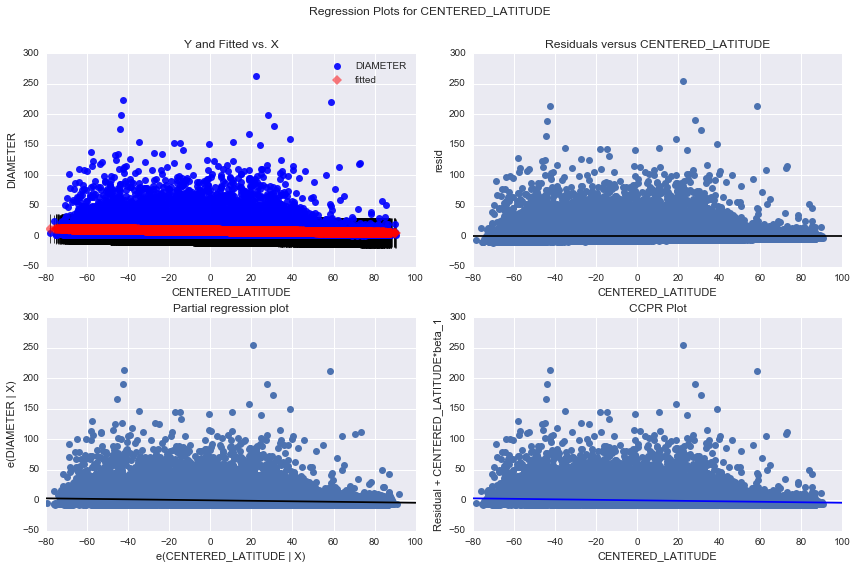

In [17]:
#Additional diagnostics of our regression
fig2 = plt.figure(figsize=[12,8])
fig2 = sm.graphics.plot_regress_exog(model6, "CENTERED_LATITUDE", fig = fig2)

(0.0, 0.0004)

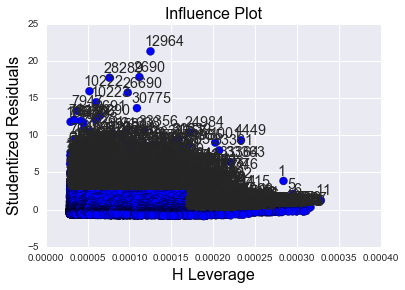

In [110]:
#Our leverage plot
fig3, ax = plt.subplots(figsize=[6,4])
fig3 = sm.graphics.influence_plot(model6,size=8,ax=ax,plot_alpha=1)
ax=fig3.axes[0]
ax.set_xlim(0.0,0.0004)

In [131]:
data4 = data3.iloc[0:100,:]
model8 = smf.ols(formula = 'DIAMETER ~ CENTERED_LATITUDE + I(CENTERED_LATITUDE**2) + CENTERED_LONGITUDE',data=data4).fit()

['__class__',
 '__delattr__',
 '__dict__',
 '__doc__',
 '__format__',
 '__getattribute__',
 '__getstate__',
 '__hash__',
 '__init__',
 '__module__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_text',
 '_adjustable',
 '_agg_filter',
 '_alpha',
 '_anchor',
 '_animated',
 '_aspect',
 '_autoscaleXon',
 '_autoscaleYon',
 '_axes',
 u'_axes_class',
 '_axes_locator',
 '_axisbelow',
 '_axisbg',
 '_cachedRenderer',
 '_clipon',
 '_clippath',
 '_connected',
 '_contains',
 '_current_image',
 '_cursorProps',
 '_frameon',
 '_gci',
 '_gen_axes_patch',
 '_gen_axes_spines',
 '_get_axis_list',
 '_get_legend_handles',
 '_get_lines',
 '_get_patches_for_fill',
 '_get_view',
 '_gid',
 '_gridOn',
 '_hold',
 '_init_axis',
 '_label',
 '_left_title',
 '_make_twin_axes',
 '_mouseover',
 '_navigate',
 '_navigate_mode',
 '_oid',
 '_originalPosition',
 '_path_effects',
 '_pcolorargs',
 '_picker',
 '_

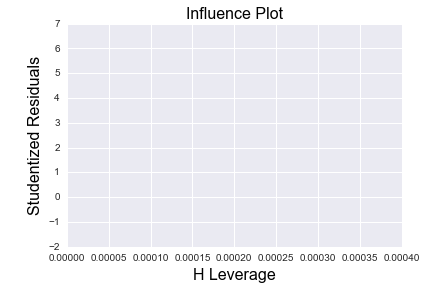

In [134]:
fig3, ax = plt.subplots(figsize=[6,4])
fig3 = sm.graphics.influence_plot(model8,size=8,ax=ax,plot_alpha=1)
ax=fig3.axes[0]
ax.set_xlim(0.0,0.0004)
ax.annotate